In [0]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


# read factors file
df = pd.read_csv('factor.csv')
print(list(df.columns))
df['temPERMNO'] = df['LPERMNO']
# fill missing value
df = df.groupby('temPERMNO').fillna(method = 'pad')

# profitability
df['equity'] = df.atq - df.ltq
df['roa'] = df.niq / df.equity
df['roe'] = df.niq / df.atq
df['roic'] = (df.niq+df.txtq+df.xintq)/(df.lltq+(df.actq-df.lctq))
# profitability's growth    Problem Here!
df['roa_pre'] = df.groupby('LPERMNO').roa.shift(1)
df['roag'] = df.roa/df.roa_pre
df['roe_pre'] = df.groupby('LPERMNO').roe.shift(1)
df['roeg'] = df.roe/df.roe_pre
# replace infinite value
df = df.replace(-np.inf,np.nan).replace(np.inf,np.nan)

df['PERMNO'] = df.LPERMNO
df['date'] = df.datadate.apply(lambda x:str(x)[:4]+'-'+str(x)[4:6])

# value
df['share_total'] = df.cshpry
df['share_common'] = df.cshoq
df['cf'] = df.oancfy
df['eps'] = df.epsf12   # eps, exclude extraordinary items

df1 = df.loc[:,['date','PERMNO','roe','roa','niq','equity','roic','roag','roeg','share_total','share_common','eps','cf','sic']]
df1.describe()

['GVKEY', 'LPERMNO', 'datadate', 'fyearq', 'fqtr', 'conm', 'actq', 'atq', 'cshoq', 'epsf12', 'lctq', 'lltq', 'ltq', 'niq', 'revtq', 'txtq', 'ugiq', 'xintq', 'cshpry', 'oancfy', 'exchg', 'sic']


,PERMNO,roe,roa,niq,equity,roic,roag,roeg,share_total,share_common,eps,cf,sic
count,197982.000000,160094.000000,160087.000000,160217.000000,160145.000000,109970.000000,156032.000000,156039.000000,160271.000000,196876.000000,137645.00000,152375.000000,197982.000000
mean,66284.309134,0.023875,0.121957,122.810403,3914.064864,0.204824,1.411451,1.418737,236.887376,197.498297,4.03097,578.986904,5053.633406
std,25437.961550,1.368672,15.367877,690.671806,13286.283882,17.889052,157.832812,154.345092,731.927535,666.166176,118.40910,3765.389844,1948.988524
min,10051.000000,-99.697674,-2024.941176,-61659.000000,-90520.000000,-710.833333,-14348.448158,-14473.812143,0.001000,0.001000,-2023.13000,-110807.000000,100.000000
25%,51263.000000,0.002903,0.010303,3.159000,250.845000,0.021467,0.450964,0.460320,27.079500,20.090000,0.43000,10.973500,3533.000000
50%,77418.000000,0.010314,0.028260,17.135000,733.313000,0.047591,0.943119,0.946092,59.863000,47.425000,1.33000,64.946000,5531.000000
75%,85348.000000,0.020598,0.048376,70.300000,2292.300000,0.088535,1.247875,1.249253,158.082500,123.740250,2.45000,272.975000,6726.000000
max,93427.000000,486.000000,5395.000000,26615.000000,258627.000000,5395.000000,31983.236515,39375.976744,39765.020000,29206.441000,8967.00000,199470.000000,9997.000000


In [0]:
len(df1.loc[(df1.equity < 0) | (df1.niq < 0)])

27124

In [0]:
ret = pd.read_csv('return.csv')
# ret1 = ret
ret1 = ret.loc[ret.PRC > 0.0,['PERMNO','RET','date','PRC']]
ret1.date = ret1.date.apply(lambda x:str(x)[-4:]+'-'+str(x)[:2])
ret1.RET = ret1.RET.replace('C',0).apply(lambda x:float(x))
ret1.head()

,PERMNO,RET,date,PRC
0,10051,-0.062500,1998-12,22.5000
1,10051,0.111111,1999-01,25.0000
2,10051,-0.392500,1999-02,15.1875
3,10051,-0.111111,1999-03,13.5000
4,10051,0.083333,1999-04,14.6250


In [0]:
# merge data, replace nan with previous data
# index by ret1, since we delete the stock whose prices are lower than 5
data1 = pd.merge(df1,ret1,on=['PERMNO','date'],how='right')
data1 = data1.sort_values(by = ['PERMNO','date'])
data1['temPERMNO'] = data1.PERMNO
data1 = data1.groupby('temPERMNO').fillna(method = 'pad')
# next term's return
data1['RETt+1'] = data1.groupby('PERMNO').RET.shift(-1)

# value factors
data1['cmkt'] = data1.PRC * data1.share_common
data1['tmkt'] = data1.PRC * data1.share_total
data1['bm'] = data1.equity / data1.cmkt
data1['ep'] = data1.eps / data1.PRC
data1['cfp'] = (data1.cf / data1.share_total) / data1.PRC
data1 = data1.replace(-np.inf,np.nan).replace(np.inf,np.nan)

data1.describe()

,PERMNO,roe,roa,niq,equity,roic,roag,roeg,share_total,share_common,eps,cf,sic,RET,PRC,RETt+1,cmkt,tmkt,bm,ep,cfp
count,650559.000000,431143.000000,431134.000000,431440.000000,431261.000000,294805.000000,421391.000000,421400.000000,431614.000000,536151.000000,377259.000000,410997.000000,539127.000000,650559.000000,650559.000000,644480.000000,5.361510e+05,4.316140e+05,430269.000000,377259.000000,410681.000000
mean,66302.368738,0.022272,0.131078,132.585670,4212.385340,0.220682,1.321981,1.179354,249.966552,206.243560,4.322536,614.667439,5067.191378,0.009586,67.010387,0.009609,5.761477e+04,7.142006e+04,0.622050,-0.021083,0.072147
std,25464.993754,0.644680,15.875890,719.826852,13804.640483,18.687047,139.753403,122.044338,753.284841,682.508072,123.781727,3932.335189,1937.931848,0.119375,2138.101758,0.119659,4.547377e+06,5.061779e+06,7.532682,3.978658,1.334883
min,10051.000000,-99.697674,-2024.941176,-61659.000000,-90520.000000,-624.666667,-14348.448158,-14473.812143,0.001000,0.001000,-2023.130000,-110807.000000,100.000000,-0.981295,0.031250,-0.981295,1.925000e-02,6.187500e-03,-2388.311688,-921.988571,-68.032560
25%,51263.000000,0.003006,0.010589,4.069000,298.178000,0.022108,0.450746,0.459257,30.341750,21.690000,0.470000,14.270000,3533.000000,-0.040157,12.170000,-0.040458,3.266799e+02,5.850541e+02,0.315484,0.023824,0.016215
50%,77366.000000,0.010351,0.028366,20.086000,827.600000,0.047823,0.941685,0.944844,65.139000,50.277000,1.380000,74.900000,5621.000000,0.008070,20.625000,0.008345,1.095668e+03,1.726832e+03,0.524377,0.050000,0.049580
75%,85440.000000,0.020398,0.048464,79.167000,2559.400000,0.087879,1.249056,1.249839,171.200000,132.024000,2.510000,301.900000,6726.000000,0.056277,36.750000,0.056478,3.972307e+03,5.685744e+03,0.804560,0.073184,0.101061
max,93427.000000,64.832168,5395.000000,26615.000000,258627.000000,5395.000000,26519.144325,39375.976744,39765.020000,29206.441000,8967.000000,199470.000000,9997.000000,5.551724,226000.000000,5.551724,5.569463e+08,5.571316e+08,1144.711959,91.786751,425.767091


In [0]:
# if income or equity < 0, replace factor with median value
data1.loc[(data1.equity < 0) | (data1.niq < 0),['roa','roe']] = np.nan
data1.loc[data1.bm < 0, 'bm'] = np.nan
data1.loc[data1.ep < 0, 'ep'] = np.nan
data1.loc[data1.cfp < 0, 'cfp'] = np.nan

# factors = ['roa','roe','roag','roeg','roic','bm','ep','cfp']

# data2 = pd.DataFrame()
# for i in sorted(list(data1.date.unique())):
#     tem = data1.loc[data1.date == i]
#     for f in factors:
#         tem[f] = tem[f].fillna(tem[f].median())
#     data2 = pd.concat([data2,tem])

# data2.describe()

In [0]:
data1.index = data1['date']
data1.sort_index(inplace = True)
data1.describe()

,PERMNO,roe,roa,niq,equity,roic,roag,roeg,share_total,share_common,eps,cf,sic,RET,PRC,RETt+1,cmkt,tmkt,bm,ep,cfp
count,650559.000000,359887.000000,359878.000000,431440.000000,431261.000000,294805.000000,421391.000000,421400.000000,431614.000000,536151.000000,377259.000000,410997.000000,539127.000000,650559.000000,650559.000000,644480.000000,5.361510e+05,4.316140e+05,421534.000000,320572.000000,351878.000000
mean,66302.368738,0.031785,0.196827,132.585670,4212.385340,0.220682,1.321981,1.179354,249.966552,206.243560,4.322536,614.667439,5067.191378,0.009586,67.010387,0.009609,5.761477e+04,7.142006e+04,0.688865,0.069092,0.106887
std,25464.993754,0.661380,16.182553,719.826852,13804.640483,18.687047,139.753403,122.044338,753.284841,682.508072,123.781727,3932.335189,1937.931848,0.119375,2138.101758,0.119659,4.547377e+06,5.061779e+06,2.755243,0.380383,1.407818
min,10051.000000,0.000000,0.000000,-61659.000000,-90520.000000,-624.666667,-14348.448158,-14473.812143,0.001000,0.001000,-2023.130000,-110807.000000,100.000000,-0.981295,0.031250,-0.981295,1.925000e-02,6.187500e-03,0.000006,0.000000,0.000000
25%,51263.000000,0.006111,0.019679,4.069000,298.178000,0.022108,0.450746,0.459257,30.341750,21.690000,0.470000,14.270000,3533.000000,-0.040157,12.170000,-0.040458,3.266799e+02,5.850541e+02,0.328020,0.038121,0.029735
50%,77366.000000,0.012775,0.033590,20.086000,827.600000,0.047823,0.941685,0.944844,65.139000,50.277000,1.380000,74.900000,5621.000000,0.008070,20.625000,0.008345,1.095668e+03,1.726832e+03,0.533668,0.056028,0.061191
75%,85440.000000,0.022541,0.053081,79.167000,2559.400000,0.087879,1.249056,1.249839,171.200000,132.024000,2.510000,301.900000,6726.000000,0.056277,36.750000,0.056478,3.972307e+03,5.685744e+03,0.812773,0.078340,0.112942
max,93427.000000,64.832168,5395.000000,26615.000000,258627.000000,5395.000000,26519.144325,39375.976744,39765.020000,29206.441000,8967.000000,199470.000000,9997.000000,5.551724,226000.000000,5.551724,5.569463e+08,5.571316e+08,1144.711959,91.786751,425.767091


In [0]:
data1 = data1.loc['1998-01':]

In [0]:
data1.columns

Index(['date', 'PERMNO', 'roe', 'roa', 'niq', 'equity', 'roic', 'roag', 'roeg',
       'share_total', 'share_common', 'eps', 'cf', 'sic', 'RET', 'PRC',
       'RETt+1', 'cmkt', 'tmkt', 'bm', 'ep', 'cfp'],
      dtype='object')

In [0]:
data1.index.rename('Index', inplace=True)

# ------   Profit  ----- #

# 1. ROE 

In [0]:
def single_factor_backtest(data,factor):
    """
    data : df
    factor : string
    """
    ## Rank 
    rank_profit = data.groupby(['date']).apply(lambda x: x.sort_values(factor, ascending=True))
    
    rank_profit['date'] = pd.to_datetime(rank_profit.date, format = '%Y-%m')
    month_list = list(rank_profit['date'].unique())

    return_data = {'g01':[ ],'g02':[ ],'g03':[ ],'g04':[ ],'g05':[ ],
                   'g06':[ ],'g07':[ ],'g08':[ ],'g09':[ ],'g10':[ ]}


    group_num = 10 ## <= 10

    for month in month_list:
        monthdata = rank_profit[rank_profit['date'] == month].sort_values(factor, ascending=True)

        monthdata.index = [i for i in range(1, len(monthdata) + 1)]
        month_index = [i for i in range(1, sum(monthdata.roe.notna()) + 1)]


        dict_keys = list(return_data.keys())

        percentile_unit = 100/group_num

        i = 0

        while i < group_num:
            temp_group = monthdata[(monthdata.index >= np.percentile(month_index,i * percentile_unit)) \
            & (monthdata.index < np.percentile(month_index,(i+1) * percentile_unit))]

            return_data[dict_keys[i]].append(temp_group['RETt+1'].mean())

            i = i + 1
    
    group_return = pd.DataFrame(return_data)
    group_return.index = month_list
    
    return group_return

In [0]:
def visualize(group_return,describe = False,bar_plot = False,Long_Only = False,Long_Short = False):
    if describe:
        group_return.describe()
    if bar_plot:
        
        group_mean_return = pd.DataFrame(group_return.mean())
        group_mean_return.plot(kind = 'bar',label='Average Ret',figsize = [8,4],legend = False,title = "Average Return of 10 Groups")
        plt.show()
        
    if Long_Only:
    
        L_strat = group_return['g10']
        fig = plt.figure(figsize = [8,4])
        plt.plot((L_strat + 1).cumprod())
        plt.title("Cummulative Return of LONG-ONLY Strategy")
        plt.show()
    if Long_Short:
        LS_strat_1001 = group_return['g10'] + (-1) * group_return['g01']
        fig = plt.figure(figsize = [8,4])
        plt.plot((LS_strat_1001 + 1).cumprod())
        plt.title("Cummulative Return of LONG-SHORT Strategy")
        plt.show()


In [0]:
roe_group_return = single_factor_backtest(data1,'roe')

In [0]:
roe_group_return.describe()

,g01,g02,g03,g04,g05,g06,g07,g08,g09,g10
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,0.008494,0.010034,0.010752,0.012432,0.012450,0.011145,0.014238,0.013678,0.014048,0.017451
std,0.060594,0.054932,0.051891,0.049525,0.049122,0.048712,0.049825,0.048988,0.049720,0.050933
min,-0.264535,-0.277974,-0.252950,-0.211421,-0.224032,-0.201403,-0.196579,-0.210422,-0.212592,-0.203524
25%,-0.018687,-0.017928,-0.014100,-0.014823,-0.012418,-0.016971,-0.010017,-0.014523,-0.015102,-0.008521
50%,0.010031,0.012578,0.011761,0.013784,0.015893,0.012869,0.016301,0.014651,0.014398,0.017925
75%,0.037384,0.042374,0.041733,0.042227,0.044261,0.042820,0.047395,0.045299,0.046672,0.052757
max,0.319810,0.266173,0.267369,0.194883,0.222952,0.169701,0.176534,0.154857,0.150241,0.163258


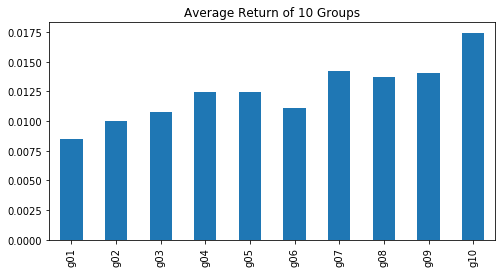

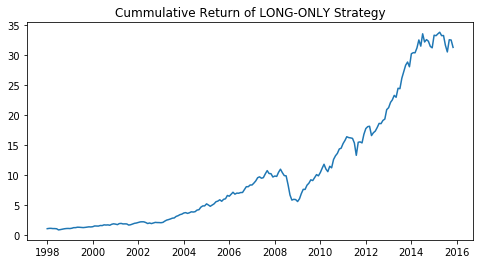

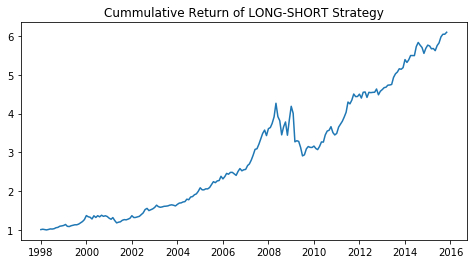

In [0]:
visualize(roe_group_return,bar_plot=True)
visualize(roe_group_return,Long_Only=True)
visualize(roe_group_return,Long_Short=True)

### since we put lots of nan into the middle

# 2. ROA

In [0]:
roa_group_return = single_factor_backtest(data1,'roa')

In [0]:
roa_group_return.describe()

,g01,g02,g03,g04,g05,g06,g07,g08,g09,g10
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,0.007392,0.009917,0.010017,0.011582,0.011220,0.012958,0.013545,0.013557,0.016025,0.018505
std,0.058999,0.054684,0.049126,0.049297,0.049280,0.048904,0.048915,0.049685,0.049492,0.053296
min,-0.286144,-0.267294,-0.230218,-0.204080,-0.211552,-0.198374,-0.216148,-0.213479,-0.212654,-0.216277
25%,-0.020089,-0.018041,-0.017548,-0.013103,-0.013688,-0.011305,-0.012614,-0.010501,-0.010216,-0.008683
50%,0.007994,0.010156,0.014169,0.012850,0.013199,0.018737,0.016904,0.016276,0.017232,0.021142
75%,0.038475,0.041788,0.041486,0.043322,0.042775,0.041295,0.042445,0.043096,0.045987,0.050911
max,0.296853,0.275471,0.198268,0.197066,0.187457,0.171291,0.166800,0.168690,0.161319,0.192083


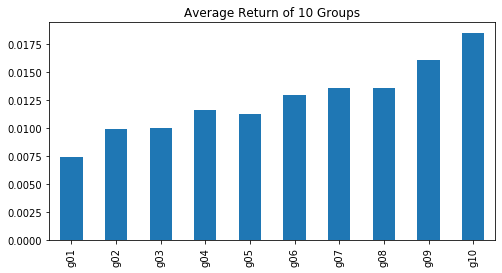

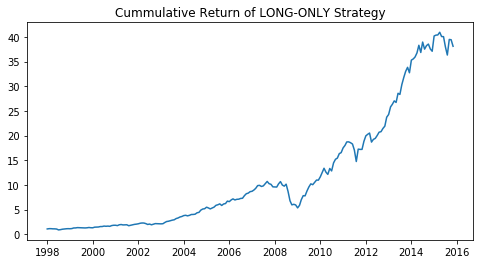

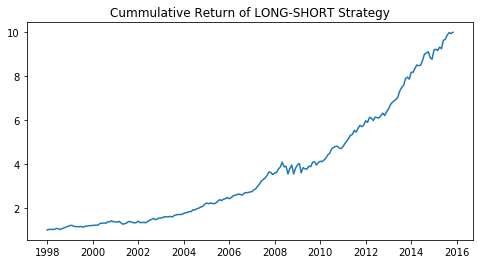

In [0]:
visualize(roa_group_return,bar_plot=True)
visualize(roa_group_return,Long_Only=True)
visualize(roa_group_return,Long_Short=True)

## 3. ROIC

In [0]:
roic_group_return = single_factor_backtest(data1,'roic')

In [0]:
roic_group_return.describe()

,g01,g02,g03,g04,g05,g06,g07,g08,g09,g10
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,0.004111,0.007843,0.012705,0.013533,0.014348,0.014905,0.013624,0.013907,0.009117,0.005490
std,0.075849,0.071491,0.065475,0.059589,0.056708,0.053353,0.050253,0.048095,0.046768,0.044938
min,-0.283791,-0.314046,-0.254406,-0.224339,-0.226771,-0.211318,-0.217911,-0.211174,-0.209440,-0.192059
25%,-0.033370,-0.025635,-0.018602,-0.019102,-0.013888,-0.014061,-0.013630,-0.014097,-0.014721,-0.016923
50%,0.000758,0.007163,0.016408,0.017170,0.017395,0.015236,0.014135,0.016215,0.012740,0.009247
75%,0.047555,0.047373,0.046638,0.048082,0.048380,0.049851,0.046788,0.045914,0.036756,0.030932
max,0.364533,0.355721,0.382883,0.336776,0.292320,0.258863,0.180235,0.159042,0.156389,0.128880


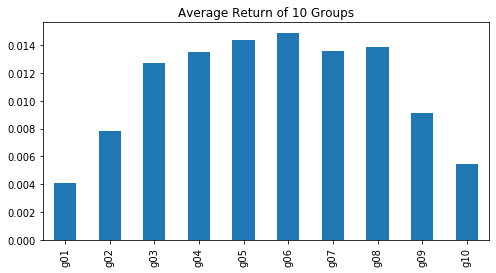

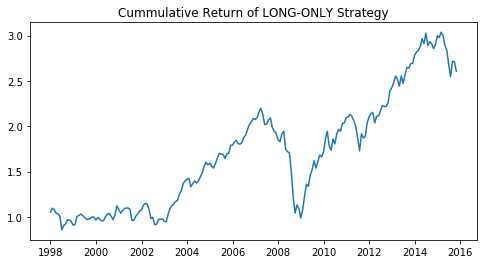

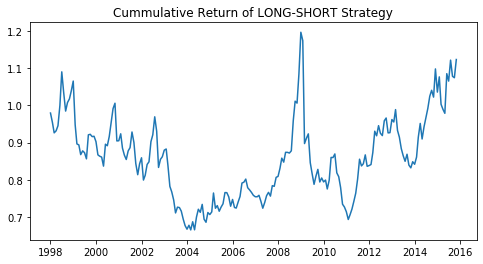

In [0]:
visualize(roic_group_return,bar_plot=True)
visualize(roic_group_return,Long_Only=True)
visualize(roic_group_return,Long_Short=True)

# -----    Value ---- #

# 1. Book to Market

In [0]:
bm_group_return = single_factor_backtest(data1,'bm')
bm_group_return.describe()

,g01,g02,g03,g04,g05,g06,g07,g08,g09,g10
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,0.009776,0.008324,0.008672,0.008673,0.009253,0.009484,0.009784,0.010921,0.011025,0.011103
std,0.047371,0.048212,0.049024,0.050115,0.050713,0.051005,0.050455,0.052554,0.054774,0.056936
min,-0.187227,-0.201905,-0.210104,-0.227625,-0.226065,-0.229958,-0.215216,-0.244851,-0.262935,-0.256648
25%,-0.018504,-0.019979,-0.019290,-0.019050,-0.016119,-0.018622,-0.016374,-0.015067,-0.016107,-0.015830
50%,0.015754,0.010643,0.010744,0.009232,0.014872,0.014859,0.015175,0.015496,0.014228,0.016289
75%,0.043257,0.039840,0.041126,0.042691,0.038746,0.040389,0.040176,0.041905,0.042051,0.040493
max,0.137994,0.127879,0.132210,0.166427,0.164654,0.154969,0.163575,0.219463,0.182465,0.252226


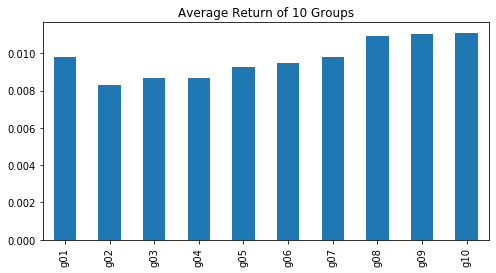

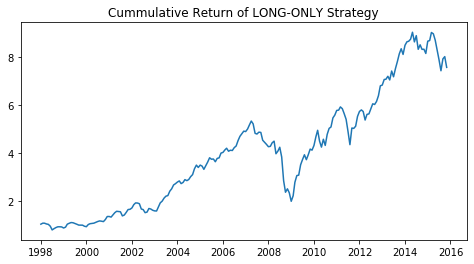

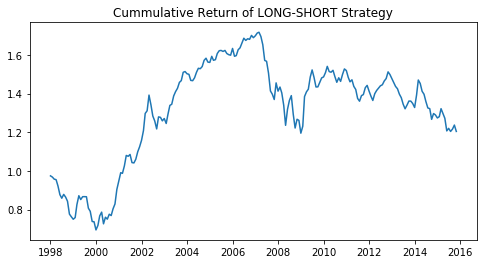

In [0]:
visualize(bm_group_return,bar_plot=True)
visualize(bm_group_return,Long_Only=True)
visualize(bm_group_return,Long_Short=True)

# 2. Earning Per Share to Price ratio

In [0]:
ep_group_return = single_factor_backtest(data1,'ep')
ep_group_return.describe()

,g01,g02,g03,g04,g05,g06,g07,g08,g09,g10
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,0.006863,0.007261,0.007054,0.008263,0.008174,0.010275,0.011425,0.014097,0.015444,0.018029
std,0.056039,0.050069,0.047143,0.044177,0.045016,0.044872,0.047465,0.050960,0.055152,0.062053
min,-0.280044,-0.235476,-0.221229,-0.189456,-0.213027,-0.190636,-0.195487,-0.219287,-0.227632,-0.242990
25%,-0.024067,-0.018694,-0.017955,-0.017701,-0.016168,-0.010800,-0.012523,-0.010305,-0.013142,-0.010433
50%,0.008206,0.011884,0.011489,0.010353,0.012709,0.012978,0.015993,0.015982,0.019001,0.022936
75%,0.044110,0.040848,0.038844,0.036656,0.037401,0.039129,0.037659,0.042928,0.046148,0.049916
max,0.208345,0.152295,0.113206,0.125040,0.137438,0.135234,0.189510,0.201385,0.253595,0.320867


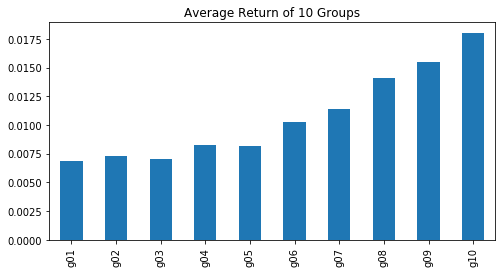

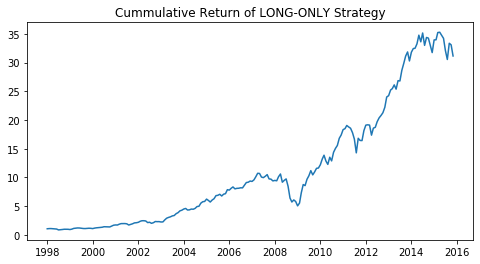

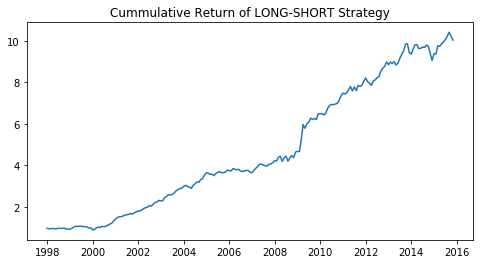

In [0]:
visualize(ep_group_return,bar_plot=True)
visualize(ep_group_return,Long_Only=True)
visualize(ep_group_return,Long_Short=True)

# 3. Cash Flow Per Share to Price Ratio

In [0]:
cfp_group_return = single_factor_backtest(data1,'ep')
cfp_group_return.describe()

,g01,g02,g03,g04,g05,g06,g07,g08,g09,g10
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,0.006863,0.007261,0.007054,0.008263,0.008174,0.010275,0.011425,0.014097,0.015444,0.018029
std,0.056039,0.050069,0.047143,0.044177,0.045016,0.044872,0.047465,0.050960,0.055152,0.062053
min,-0.280044,-0.235476,-0.221229,-0.189456,-0.213027,-0.190636,-0.195487,-0.219287,-0.227632,-0.242990
25%,-0.024067,-0.018694,-0.017955,-0.017701,-0.016168,-0.010800,-0.012523,-0.010305,-0.013142,-0.010433
50%,0.008206,0.011884,0.011489,0.010353,0.012709,0.012978,0.015993,0.015982,0.019001,0.022936
75%,0.044110,0.040848,0.038844,0.036656,0.037401,0.039129,0.037659,0.042928,0.046148,0.049916
max,0.208345,0.152295,0.113206,0.125040,0.137438,0.135234,0.189510,0.201385,0.253595,0.320867


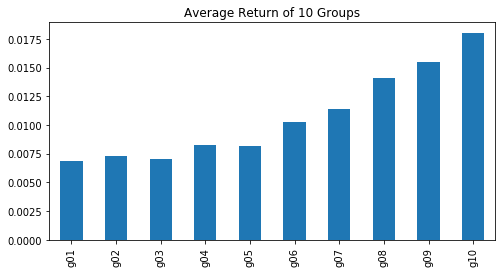

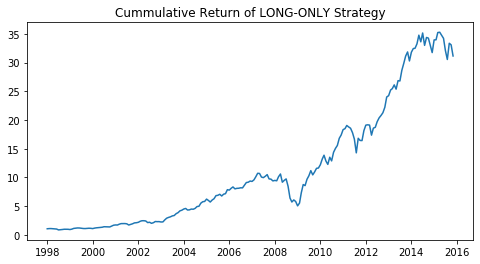

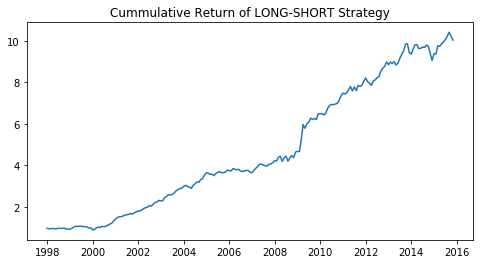

In [0]:
visualize(cfp_group_return,bar_plot=True)
visualize(cfp_group_return,Long_Only=True)
visualize(cfp_group_return,Long_Short=True)

# ---- Done ------ #

### Get the factor return

In [0]:
def get_factor_return(factor_group):
    low_return = factor_group[['g01']].mean(axis=1)
    high_return = factor_group[['g10']].mean(axis=1)
    return_diff = high_return - low_return
    return high_return, low_return, return_diff 

In [0]:
factor_list = [roe_group_return, roa_group_return, roic_group_return, bm_group_return, ep_group_return, cfp_group_return]
factor_high_return = pd.DataFrame()
factor_low_return = pd.DataFrame()
factor_diff_return = pd.DataFrame()
for f in factor_list:
    temp1, temp2, temp3 = get_factor_return(f)
    factor_high_return = pd.concat([factor_high_return, temp1], axis=1)
    factor_low_return = pd.concat([factor_low_return, temp2], axis=1)
    factor_diff_return = pd.concat([factor_diff_return, temp3], axis=1)


for i in [factor_high_return, factor_low_return, factor_diff_return]:
    i.columns = ['roe', 'roa', 'roic', 'bm', 'ep', 'cfp']
    i.index = i.index.map(lambda x: str(x.year) + '-' + str(x.month) if x.month >= 10 else str(x.year) + '-0' + str(x.month))
    i = i.dropna()

In [0]:
factor_high_return['date'] = factor_high_return.index
factor_low_return['date'] = factor_low_return.index
factor_diff_return['date'] = factor_diff_return.index

### Regression of return on factors

In [0]:
import statsmodels.api as sm
from scipy.stats import ttest_ind

In [0]:
# del extra data
def del_extra(df):
    for c in df.columns[1:-1]:
        mean_ = np.mean(df[c])
        std_ = np.std(df[c])
        df[c] = df[c].apply(lambda x: mean_+std_ if x>mean_+std_ 
                            else mean_-std_ if x<mean_-std_ 
                            else x)
    return df
# Scale
def stand(df):
    mean_ = df.min()
    std_ = df.max()
    df = (df - mean_) / std_
    return df

In [0]:
data2.head()

,date,PERMNO,roe,roa,roic,roag,roeg,bm,ep,cfp,RETt+1
Index,,,,,,,,,,,
1998-01,1998-01,76660,0.041366,0.074384,0.112117,1.007124,1.075582,0.135996,NaN,0.010303,0.201597
1998-01,1998-01,76595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010251
1998-01,1998-01,76569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006364
1998-01,1998-01,45583,0.004341,0.009442,0.020823,-0.139322,-0.145465,0.824789,NaN,0.123764,0.002717
1998-01,1998-01,76708,0.034976,0.069554,0.713122,1.236170,1.197378,0.114868,0.025785,0.029558,0.123967


In [0]:
data2 = data1[['date', 'PERMNO', 'roe', 'roa', 'roic', 'roag', 'roeg', 'bm','ep', 'cfp', 'RETt+1']]
data3 = pd.DataFrame()
for t in sorted(list(data2.date.unique())):
    temp1 = data2[data2.date == t]
    temp2 = del_extra(temp1.iloc[:,1:])
    temp3 = stand(temp2)
    temp3['date'] = t
    temp3['PERMNO'] = temp2.PERMNO
    temp3['RETt+1'] = temp2['RETt+1']
    data3 = pd.concat([data3, temp3])

In [0]:
# Load market data and risk free rate
market_return = pd.read_csv('markets_return.csv')
risk_free = pd.read_csv('risk_free.csv')

risk_free['date'] = risk_free.MCALDT.apply(lambda x: str(x)[:7])
risk_free['rf'] = risk_free.TMYTM / 100

market_return = market_return.rename(columns={'vwretd':'ret'})
market_return['ret_market'] = market_return.ret.shift(-1)
market_return['date'] = market_return.DATE.apply(lambda x: str(x)[:4] + '-' + str(x)[4:6])
market_return.drop(['DATE'],axis=1, inplace=True)

data4 = data3.merge(market_return[['date','ret_market']], left_on='date', right_on='date', how='left').merge(risk_free[['date', 'rf']], left_on='date', right_on='date', how='left')
data4['market_excess_return'] = data4['ret_market'] - data4['rf']
data4['stock_excess_return'] = data4['RETt+1'] - data4['rf']

#### Single factor Alpha

In [0]:
factor_high_return1 = factor_high_return.merge(market_return[['date','ret_market']], left_on='date', right_on='date', how='left').merge(risk_free[['date', 'rf']], left_on='date', right_on='date', how='left')
factor_high_return1['market_excess_return'] = factor_high_return1['ret_market'] - factor_high_return1['rf']
factor_low_return1 = factor_low_return.merge(market_return[['date','ret_market']], left_on='date', right_on='date', how='left').merge(risk_free[['date', 'rf']], left_on='date', right_on='date', how='left')
factor_low_return1['market_excess_return'] = factor_low_return1['ret_market'] - factor_low_return1['rf']
factor_diff_return1 = factor_diff_return.merge(market_return[['date','ret_market']], left_on='date', right_on='date', how='left').merge(risk_free[['date', 'rf']], left_on='date', right_on='date', how='left')
factor_diff_return1['market_excess_return'] = factor_diff_return1['ret_market'] - factor_diff_return1['rf']
# factor_return1['stock_excess_return'] = factor_return1 - factor_return1['rf']

In [0]:
stocks_list = data1.PERMNO.unique()
# factor_return1 = factor_return.merge(market_return[['date','ret_market']], left_on='date', right_on='date', how='left').merge(risk_free[['date', 'rf']], left_on='date', right_on='date', how='left')
# factor_return1['market_excess_return'] = factor_return1['ret_market'] - factor_return1['rf']
# factor_return1['stock_excess_return'] = factor_return1['RETt+1'] - factor_return1['rf']

#Do regression for every stock
stats_dict = {0:[], 1:[], 2:[]}
tvalues_dict = {0:[], 1:[], 2:[]}
factors = ['roe', 'roa', 'roic', 'bm', 'ep', 'cfp']
portfolios = [factor_high_return1, factor_low_return1, factor_diff_return1]
for i in range(len(portfolios)):
    for f in factors:
        factor_ret = portfolios[i][f] - portfolios[i]['rf']
        market_ret = portfolios[i]['market_excess_return']
        # Make sure there is enough data
        if len(ret) >= 20:
            regressors = sm.add_constant(np.array(market_ret))
            reg = sm.OLS(np.array(factor_ret), regressors, missing='drop').fit()
            stats_dict[i].append(reg.params)
            tvalues_dict[i].append(reg.tvalues)
            # time = ret.index
            # factor = sm.add_constant(np.array(factor_return.roe.loc[time]))
            # reg = sm.OLS(np.array(ret), factor).fit()
            # stats_list.append(reg.params)
            # pvalues.append(reg.pvalues)

In [0]:
high_stats_df = pd.DataFrame(stats_dict[0], columns=['alpha', 'beta'], index=factors)
low_stats_df = pd.DataFrame(stats_dict[1], columns=['alpha', 'beta'], index=factors)
diff_stats_df = pd.DataFrame(stats_dict[2], columns=['alpha', 'beta'], index=factors)

In [0]:
# high return group alpha
print('high return group alpha: ')
print(high_stats_df)
# low return group alpha
print('low return group alpha: ')
print(low_stats_df)

high return group alpha: 
         alpha      beta
roe   0.010890  0.972478
roa   0.012486  1.011964
roic -0.002598  0.861313
bm    0.004886  0.997519
ep    0.012924  1.078576
cfp   0.012924  1.078576
low return group alpha: 
         alpha      beta
roe   0.003323  1.073740
roa   0.001769  1.040870
roic  0.001872  1.287314
bm    0.003044  0.959967
ep    0.001682  1.073018
cfp   0.001682  1.073018


#### Regression on factors values

#### Multi factor model

In [0]:
data4[data4.date!='2015-12']

,PERMNO,roe,roa,roic,roag,roeg,bm,ep,cfp,RETt+1,date,ret_market,rf,market_excess_return,stock_excess_return
0,76660,0.579996,0.059427,0.511866,0.501373,0.496912,0.122892,NaN,0.049604,0.201597,1998-01,0.073303,0.050254,0.023049,0.151343
1,76595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010251,1998-01,0.073303,0.050254,0.023049,-0.060505
2,76569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006364,1998-01,0.073303,0.050254,0.023049,-0.056618
3,45583,0.060867,0.007544,0.482355,0.476789,0.473173,0.789878,NaN,0.599797,0.002717,1998-01,0.073303,0.050254,0.023049,-0.047537
4,76708,0.490411,0.055568,0.706144,0.506284,0.499280,0.102433,0.149119,0.142976,0.123967,1998-01,0.073303,0.050254,0.023049,0.073713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553178,86870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028235,2015-11,-0.022288,0.001217,-0.023505,0.027018
553179,14638,0.001522,0.003175,NaN,0.514726,0.514109,0.444580,0.146041,0.302792,0.005687,2015-11,-0.022288,0.001217,-0.023505,0.004470
553180,14214,0.034932,0.059653,0.506790,0.517287,0.518267,0.201767,0.778913,0.275558,-0.120838,2015-11,-0.022288,0.001217,-0.023505,-0.122055
553181,89330,NaN,NaN,0.498672,0.503948,0.501743,1.000000,NaN,0.446524,-0.023739,2015-11,-0.022288,0.001217,-0.023505,-0.024956


In [0]:
data5 = data4[data4.date != '2015-12']
time = data5.date.unique()

#Do regression for every stock
stats_list = []
tvalues = []
time_list = []
pvalues = []
factors = ['roe', 'roa', 'roic', 'bm', 'ep', 'cfp']

for t in time:
    sample = data5[data5.date == t]
    sample = sample.dropna()
    ret = sample['stock_excess_return']
    # Make sure there is enough data
    if len(ret) >= 0:
        regressors = sm.add_constant(np.array(sample[factors]))
        reg = sm.OLS(np.array(ret), regressors).fit()
        stats_list.append(reg.params)
        tvalues.append(reg.tvalues)
        time_list.append(t)
        # time = ret.index
        # factor = sm.add_constant(np.array(factor_return.roe.loc[time]))
        # reg = sm.OLS(np.array(ret), factor).fit()
        # stats_list.append(reg.params)
        # pvalues.append(reg.pvalues)

In [0]:
params_df = pd.DataFrame(stats_list, columns=['alpha', 'roe', 'roa', 'roic', 'bm', 'ep', 'cfp'])
params_df['date'] = time_list
# params_df.index = params_df['date']
tvalues_df = pd.DataFrame(tvalues, columns=['alpha', 'roe', 'roa', 'roic', 'bm' ,'ep', 'cfp'])
tvalues_df['date'] = time_list
# tvalues_df.index = tvalues_df['date']

In [0]:
import seaborn as sns
import matplotlib.ticker as ticker

Text(0.5, 1.0, 'CFP')

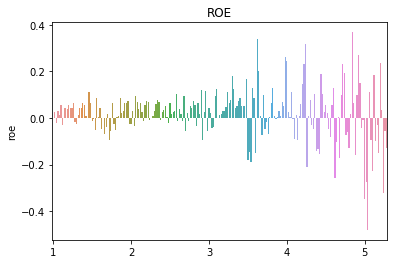

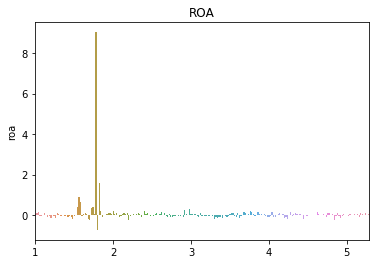

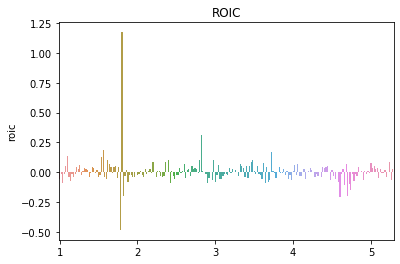

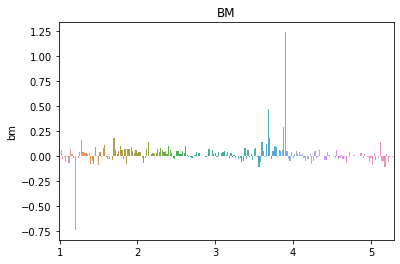

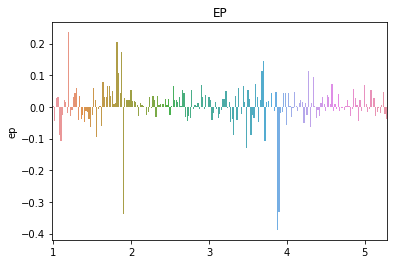

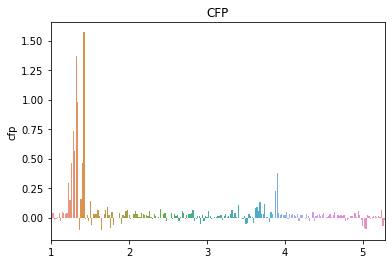

In [0]:
fig, ax = plt.subplots(1,1)
sns.barplot(x = params_df.index,y = 'roe', data=params_df)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.title('ROE')

fig, ax = plt.subplots(1,1)
sns.barplot(x = params_df.index,y = 'roa', data=params_df)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.title('ROA')

fig, ax = plt.subplots(1,1)
sns.barplot(x = params_df.index,y = 'roic', data=params_df)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.title('ROIC')

fig, ax = plt.subplots(1,1)
sns.barplot(x = params_df.index,y = 'bm', data=params_df)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.title('BM')

fig, ax = plt.subplots(1,1)
sns.barplot(x = params_df.index,y = 'ep', data=params_df)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.title('EP')

fig, ax = plt.subplots(1,1)
sns.barplot(x = params_df.index,y = 'cfp', data=params_df)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.title('CFP')

In [0]:
tvalues_df = tvalues_df.drop(['date'],axis=1)

In [0]:
tvalues_df.apply(abs).mean()

alpha    1.292880
roe      1.463751
roa      0.968859
roic     0.822043
bm       1.979876
ep       1.570122
cfp      1.638357
dtype: float64